In [1]:
from Online_Update import test_then_train_env
from Online_Models import Online_Diffusion, Online_Xgboost, Online_MA, ELM, Online_GCN, Online_GAT, Online_LSTM, Online_Diffusion_Density, Single_Model
from Online_Models import Online_Diffusion_UQ
from lib.utils import gen_data_dict, process_sensor_data
from lib.utils import seperate_up_down
import random
import torch
import pickle
import numpy as np
preds = {}
error_dict = {}
model_dict = {}
v_dict = {}
alpha_dict = {}
e_dict = {}

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1)
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict)
data_dict = gen_data_dict(df_dict)
# online testing
# dataset_name = "crossroad"
dataset_name = "train_station"
# test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
#        'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8', 'sc_sensor/crossroad2_2']
# train_sc = ['sc_sensor/crossroad3']
# test_sc = ['sc_sensor/crossroad3']
# train_sc = ['sc_sensor/train3']
test_sc = ['sc_sensor/train1','sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4']

#seperate upstream and downstream
data_dict = seperate_up_down(data_dict)

if dataset_name == "crossroad":
    file_path = 'graphs/graph_data_crossroad.pkl'
    with open(file_path, 'rb') as file:
        g = pickle.load(file)

elif dataset_name == "train_station":
    file_path = 'graphs/graph_data_trainstation.pkl'
    with open(file_path, 'rb') as file:
        g = pickle.load(file)

chunk_size = 30
lags = 5
'''Has to >= 2'''
pred_horizon = 5 # 3, 5
test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g)

In [4]:
# mdl = "ma"
# mdl = "diffusion"
# mdl = "diffusion_uq"
# mdl = "diffusion_density"
# mdl = "xgboost"
# mdl = "elm"
# mdl = "gcn"
# mdl = "gat"
mdl = "lstm"
if mdl == "diffusion":
    model = Single_Model(model_type=Online_Diffusion, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=130, buffer=True)
elif mdl == "xgboost":
    model = Single_Model(model_type=Online_Xgboost, g=g, data_name=dataset_name, pred_horizon=pred_horizon,
                         lags=lags, device=device, chunk_size=chunk_size, train_steps=None, buffer=False)
elif mdl == "ma":
    model = Single_Model(model_type=Online_MA, g=g, pred_horizon=pred_horizon, lags=lags, device=device, train_steps=None)
elif mdl == "elm":
    model = Single_Model(model_type=ELM, g=g, pred_horizon=pred_horizon, lags=lags, device=None, hidden_units=64, train_steps=None, buffer=False)
elif mdl == "gcn":
    model = Single_Model(model_type=Online_GCN, chunk_size=chunk_size, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=128, train_steps=100)
elif mdl == "gat":
    model = Single_Model(model_type=Online_GAT, g=g, hidden_units=32, pred_horizon=pred_horizon, 
                         lags=lags, device=device, num_heads=3, train_steps=200, chunk_size=chunk_size)
elif mdl == "lstm":
    model = Single_Model(model_type=Online_LSTM, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=64, chunk_size=chunk_size, num_layers=2, train_steps=200, buffer=True)
elif mdl == "diffusion_uq":
    model = Single_Model(model_type=Online_Diffusion_UQ, g=g, pred_horizon=pred_horizon, lags=lags, device=device,
                         train_steps=130, chunk_size=chunk_size, buffer=True)
elif mdl == "diffusion_density":
    model = Single_Model(model_type=Online_Diffusion_Density, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=150, buffer=True)
else:
    raise ValueError("model type not found")
# model, curve_data, preds[mdl] = test_env.test_then_train(model)
model, curve_data, preds[mdl], v, alpha, e = test_env.test_then_train(model)
error_dict[mdl] = curve_data
model_dict[mdl] = model
if mdl in ["diffusion", "diffusion_uq", "diffusion_density"]:
    v_dict[mdl] = torch.cat(v, dim=1).detach().numpy()
    alpha_dict[mdl] = torch.cat(alpha, dim=1).detach().numpy()
    e_dict[mdl] = torch.cat(e, dim=1).detach().numpy()

error per sc_sensor/train1 chunk: 0: 4.480818271636963
error per sc_sensor/train1 chunk: 30: 6.113382816314697
error per sc_sensor/train1 chunk: 60: 4.218622207641602
error per sc_sensor/train1 chunk: 90: 4.393531799316406
error per sc_sensor/train1 chunk: 120: 3.4739959239959717
error per sc_sensor/train1 chunk: 150: 3.4490318298339844
error per sc_sensor/train1 chunk: 180: 4.003898620605469
error per sc_sensor/train1 chunk: 210: 2.9393539428710938
error per sc_sensor/train1 chunk: 240: 3.3088176250457764
error per sc_sensor/train1 chunk: 270: 3.609776258468628
error per sc_sensor/train1 chunk: 300: 2.792768955230713
error per sc_sensor/train3 chunk: 0: 2.214721202850342
error per sc_sensor/train3 chunk: 30: 3.16481351852417
error per sc_sensor/train3 chunk: 60: 2.553054094314575
error per sc_sensor/train3 chunk: 90: 2.9015047550201416
error per sc_sensor/train3 chunk: 120: 3.1639790534973145
error per sc_sensor/train3 chunk: 150: 2.279572010040283
error per sc_sensor/train3 chunk: 18

In [6]:
from lib.utils import sliding_win
label_list = []
sigma_list = []
# model = model_dict["diffusion_uq"]
for sc in test_sc:
    data = data_dict[sc]

    observation, label = sliding_win(data, lags=test_env.lags, horizons=test_env.pred_horizon)
    observation, label = torch.FloatTensor(observation).permute(2, 0, 1), torch.FloatTensor(label).permute(2, 0, 1)
    for i in range(0, observation.shape[1] - test_env.chunk_size, test_env.chunk_size):
        # pred = model.predict(observation[:, i:i+chunk_size, :])
        try:
            sigma_list.append(model.model.g.ndata['sigma'])
        except:
            pass
        label_list.append(label[:, i:i+test_env.chunk_size, :])

labels = torch.stack(label_list, dim=0)
sigma = torch.stack(sigma_list, dim=0).detach()

RuntimeError: stack expects a non-empty TensorList

In [7]:
# visualize preds and labels
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
node = 7
step = -1

label = np.transpose(labels, [0, 2, 1, 3]).reshape(-1, labels.shape[1], labels.shape[3])
def visualize(mdl, preds, label, step, node):
    time = 1500
    start = 10
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3]) # [batch, node, horizon]
    plt.figure(figsize=(20, 5))
    x = np.arange(time - start)

    sns.lineplot(x=x, y=label[start:time, node, step], label='label')
    sns.lineplot(x=x, y=pred[start:time, node, step], label='pred')
    if mdl == "diffusion_uq":
        # sigma = torch.stack(sigma_list, dim=0)
        sig = sigma.permute(2, 0, 1).reshape([-1, sigma.shape[1]]).numpy()
        sig = np.sqrt(pred[:, :, step] + pred[:, :, step] ** 2 * sig)
        plt.fill_between(x, pred[start:time, node, 0] - 2 * sig[start:time, node], pred[start:time, node, 0] + 2 * sig[start:time, node], alpha=0.5)

    #limit
    plt.ylim(0, 35)

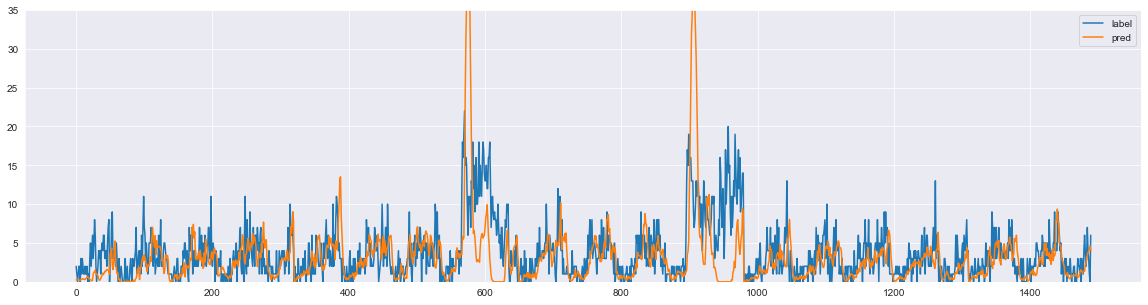

In [8]:
visualize("diffusion", preds, label, -1, 2)

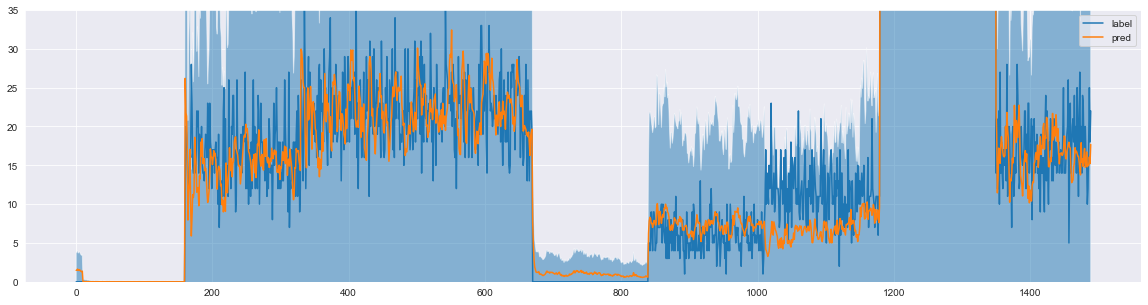

In [26]:
visualize("diffusion_uq", preds, label, -1, 2)

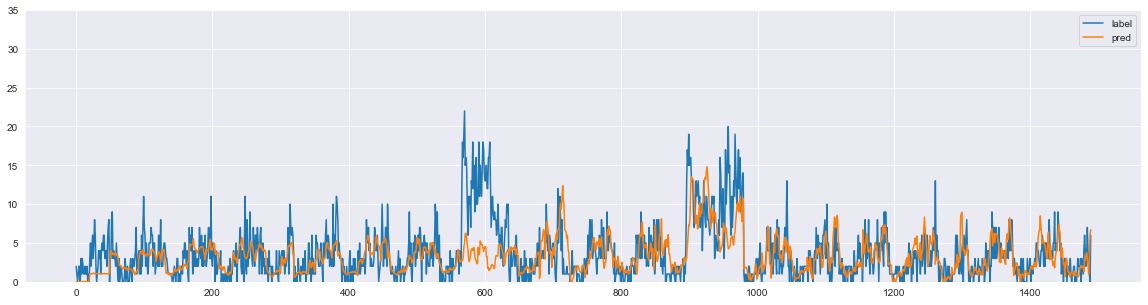

In [18]:
visualize("lstm", preds, label, -1, 2)

In [19]:
visualize("ma", preds, label, -1, 2)

KeyError: 'ma'

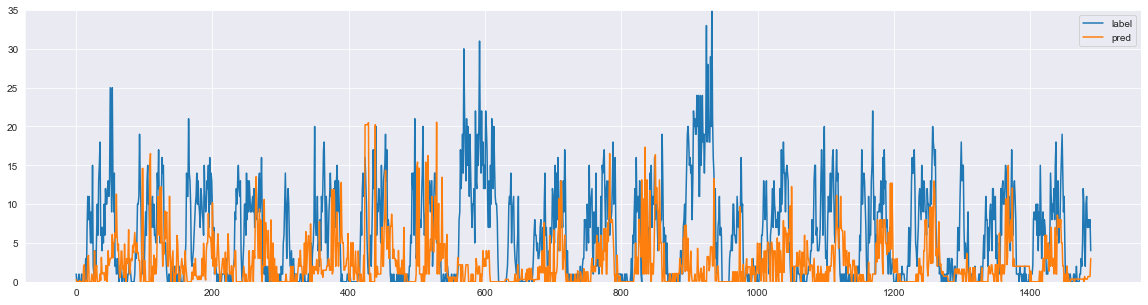

In [122]:
visualize("xgboost", preds, label, -1, 1)

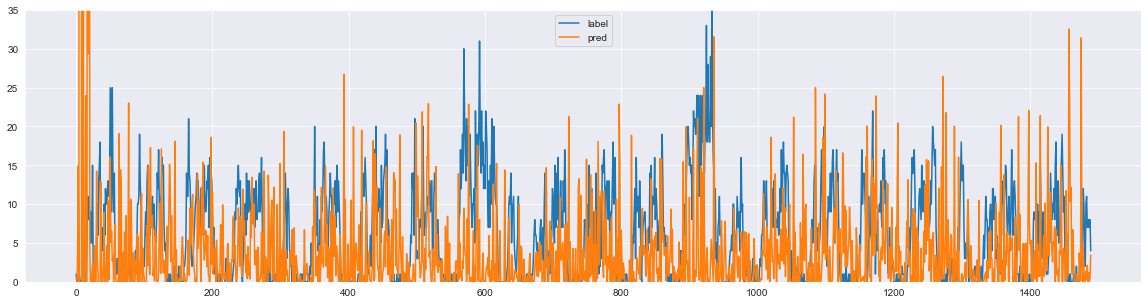

In [128]:
visualize("elm", preds, label, -1, 1)

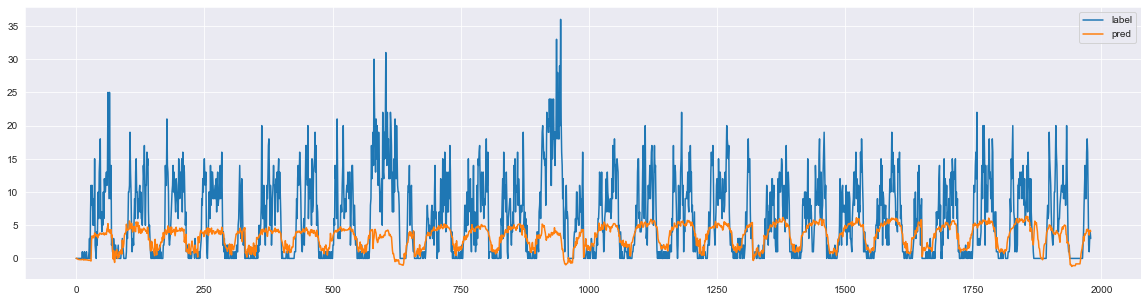

In [9]:
visualize("gat", preds, label, 1, 1)

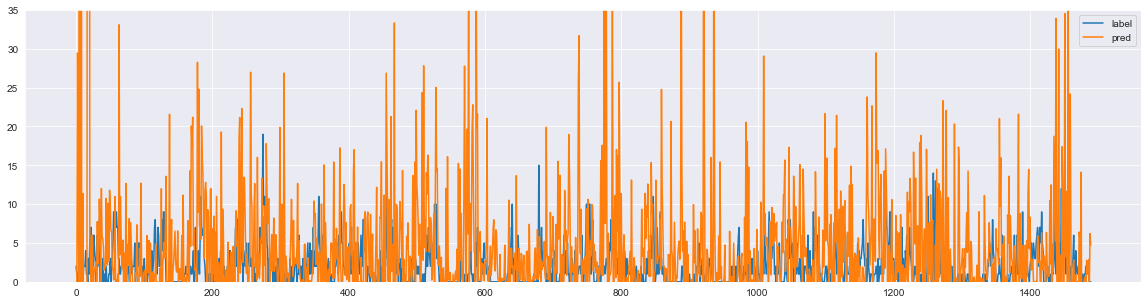

In [125]:
visualize("elm", preds, label, -1, 15)

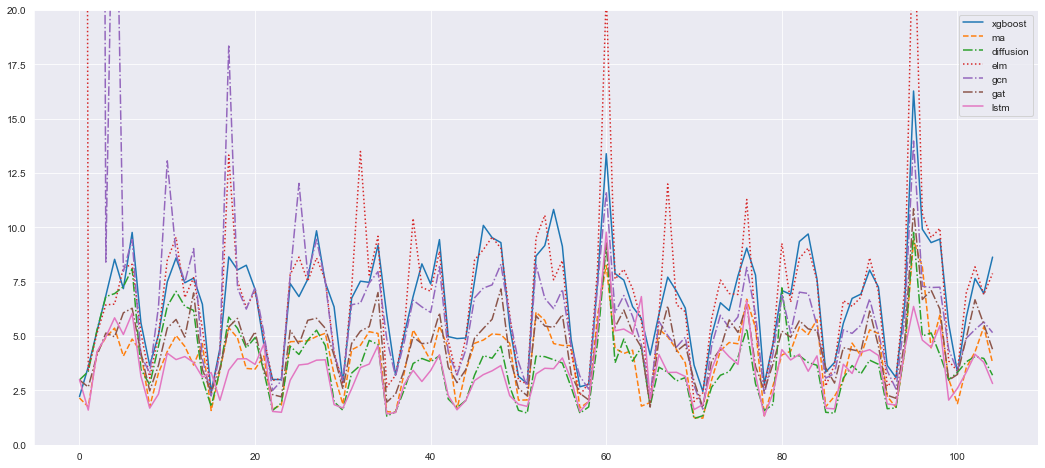

In [31]:
# visualize error
x = np.arange(len(error_dict[mdl]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=error_dict[mdl_name], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)


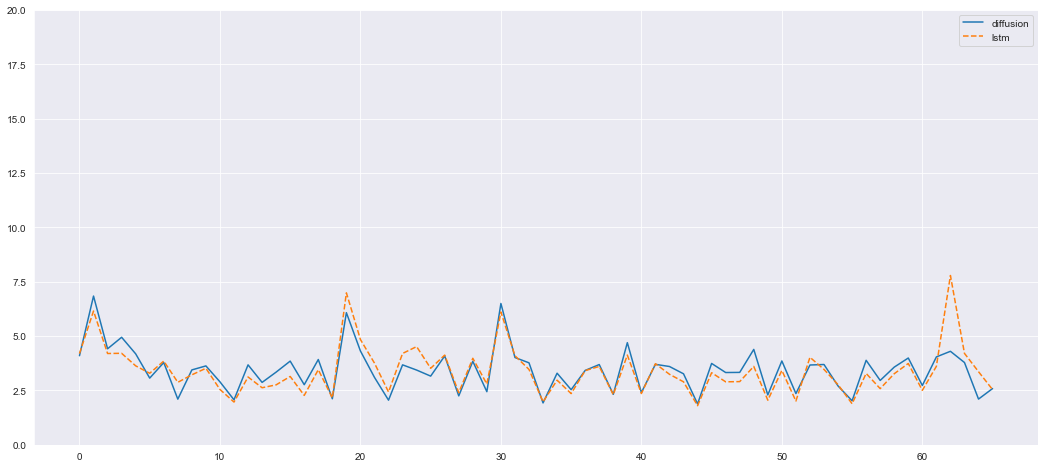

In [10]:
x = np.arange(len(error_dict[mdl]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=np.mean(error_dict[mdl_name][:, :], axis=1), label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)

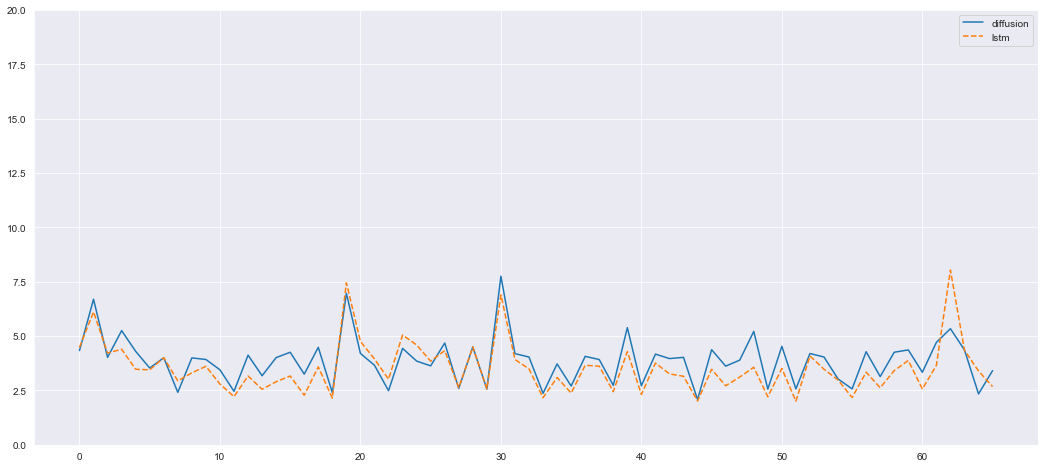

In [9]:
x = np.arange(len(error_dict[mdl]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=error_dict[mdl_name][:, 3], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)

In [29]:
torch.save(model_dict["diffusion_density"].model.model.state_dict(), "./checkpoint/diffusion/online_diffusion_density.pth")

In [46]:
import numpy as np
dataset = "train_station"
# dataset = "crossroad"
error = np.load(f"./checkpoint/{dataset}_curve_error.npy")
v = np.load(f"./checkpoint/{dataset}_v.npy")
alpha = np.load(f"./checkpoint/{dataset}_alpha.npy")

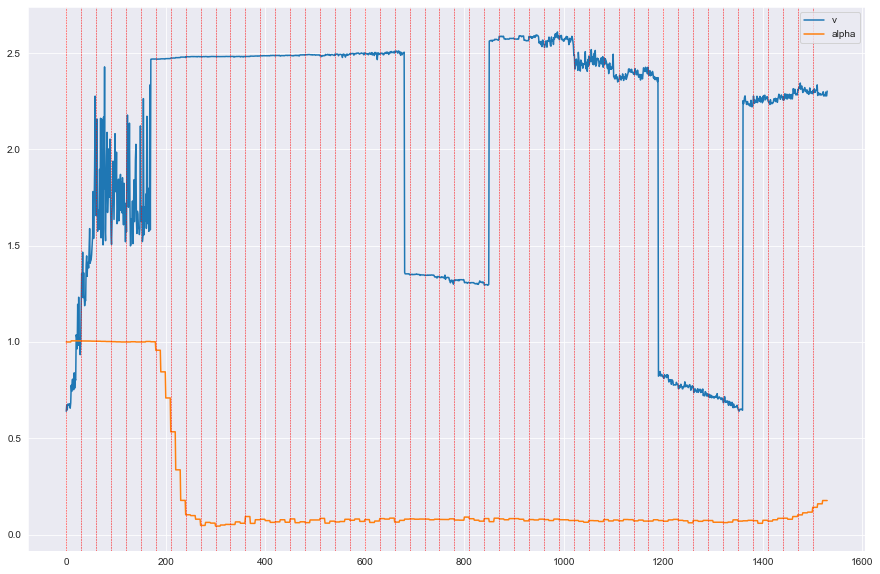

In [28]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
src = 0
dst = 7
# try:
#     v = torch.cat(v, dim=1).detach().numpy()
#     alpha = torch.cat(alpha, dim=1).detach().numpy()
# except:
#     pass
v = v_dict["diffusion_uq"]
alpha = alpha_dict["diffusion_uq"]
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], 30):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

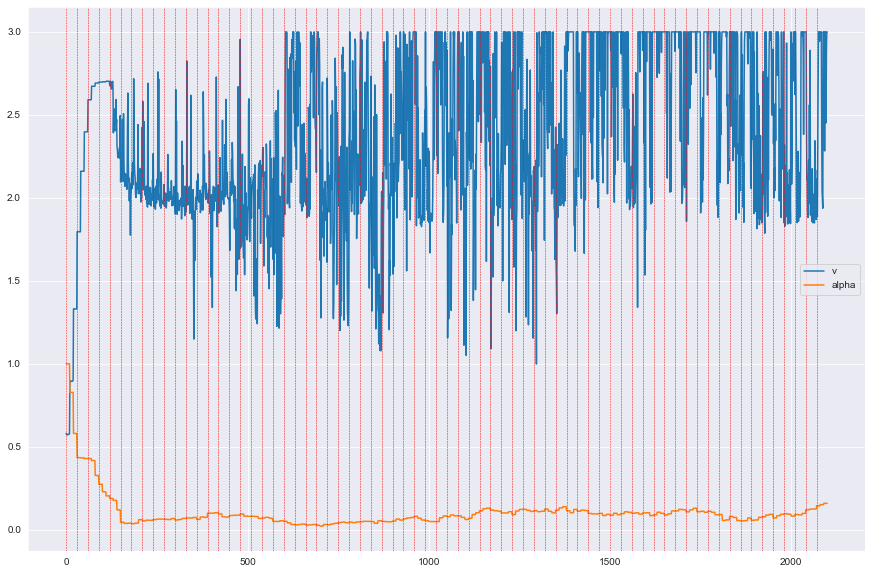

In [14]:
src = 3
dst = 6
v = v_dict["diffusion"]
alpha = alpha_dict["diffusion"]
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], 30):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

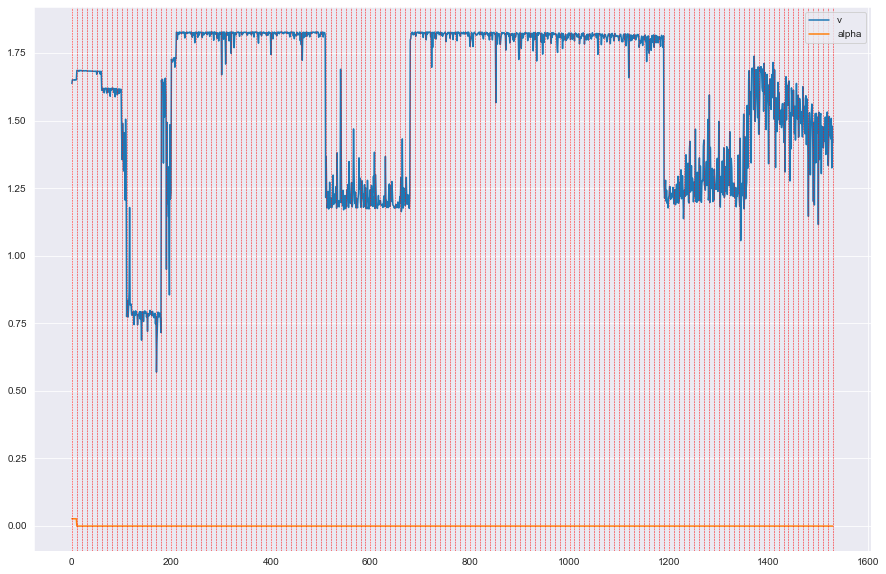

In [95]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
src = 0
dst = 4
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1]+10, 10):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

In [6]:
alpha[edge_id, :]

array([ 0.1       ,  0.1       ,  0.1       , ..., -0.04154234,
       -0.04154234, -0.04154234], dtype=float32)

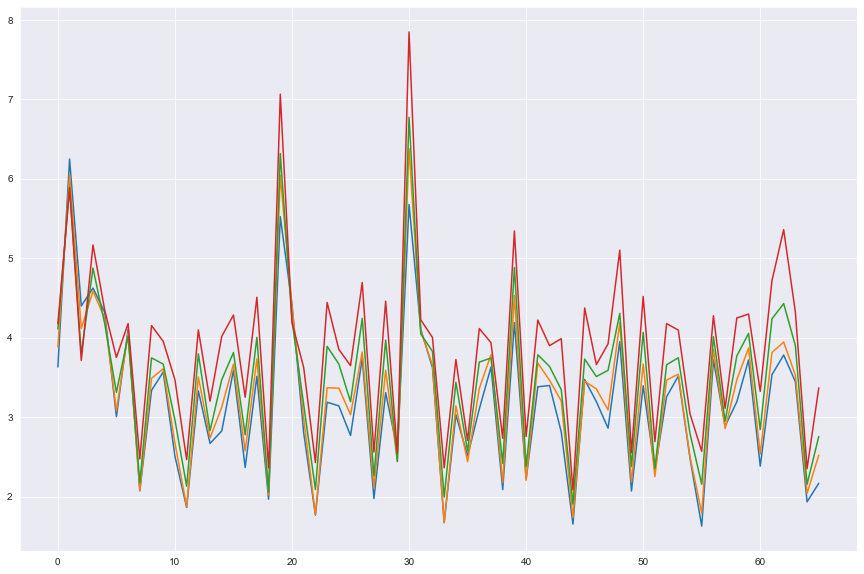

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(error.shape[0]), error)

In [45]:
alpha = alpha_dict["diffusion"]

In [51]:
num_nodes = g.number_of_nodes()
src, dst = g.edges()
with torch.no_grad():
    num_edges = len(src)
    sample_size = alpha.shape[1]
    atten_mat = np.zeros([num_nodes, num_nodes, sample_size])
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = alpha[i, :]

<AxesSubplot:>

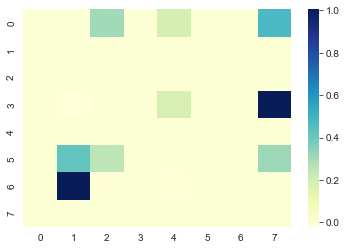

In [58]:
# visualize attention matrix
import seaborn as sns
sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")